In [53]:
import folium
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd

In [54]:
df = pd.read_csv('data/rightmove/housing_data_22-02-2019.csv', index_col=0)
df = df.dropna()
df['price'] = df['price'].str.replace('£','')
df = df[df['price']!='Coming Soon']
df['price'] = pd.to_numeric(df['price'].str.replace(',',''))
df = df.reset_index(drop=True)

In [55]:
bermondsey_map = folium.Map(location=[51.4986, -0.0691],
                    zoom_start = 13)
for index, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['address']).add_to(bermondsey_map)

In [56]:
bermondsey_map

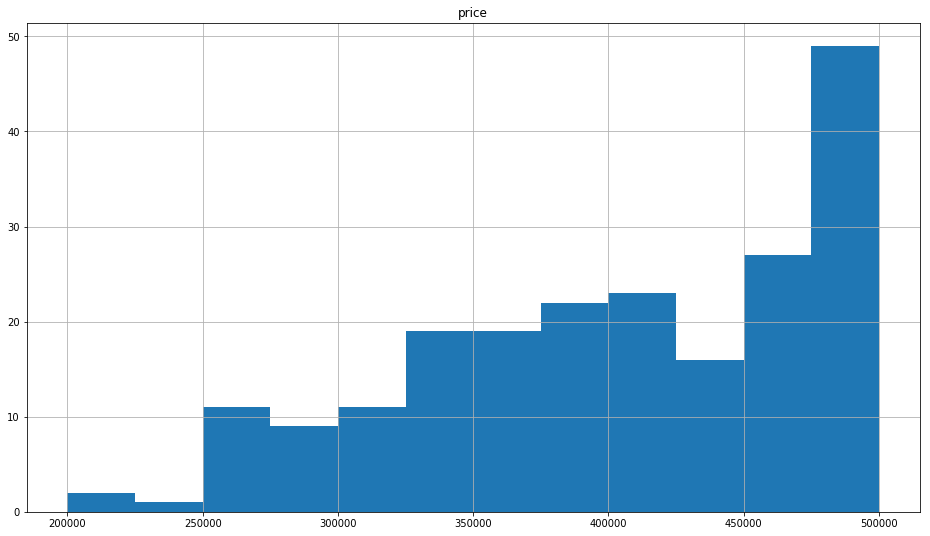

In [83]:
fig, ax = plt.subplots(figsize=(16,9))

df.hist('price', ax=ax, bins=12)

plt.show()

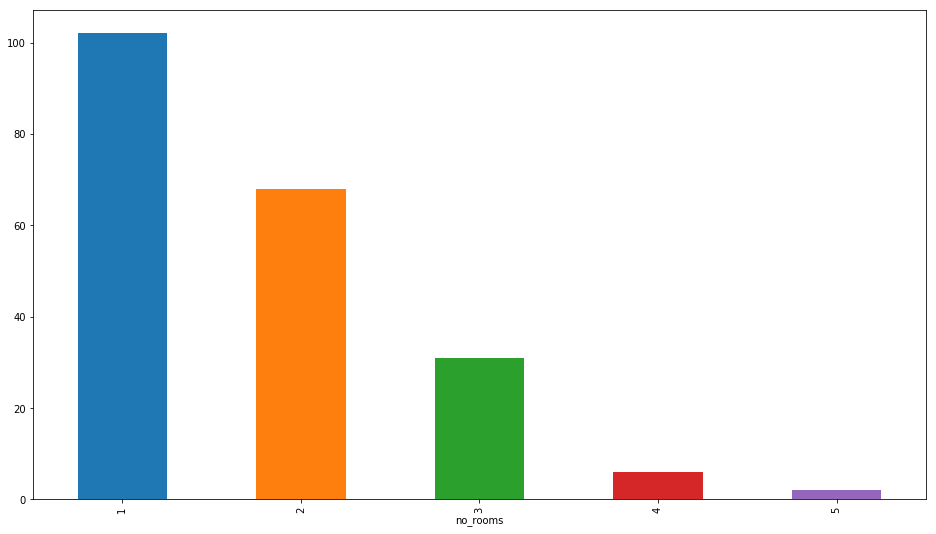

In [98]:
fig, ax = plt.subplots(figsize=(16,9))

df.groupby('no_rooms')['no_rooms'].count().plot.bar(ax=ax)

plt.show()

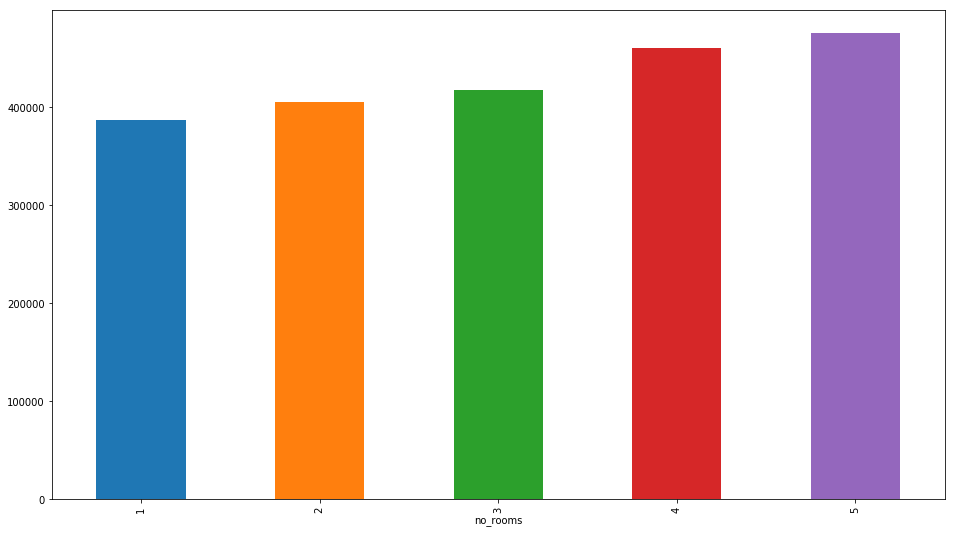

In [101]:
fig, ax = plt.subplots(figsize=(16,9))

df.groupby('no_rooms')['price'].mean().plot.bar(ax=ax)

plt.show()

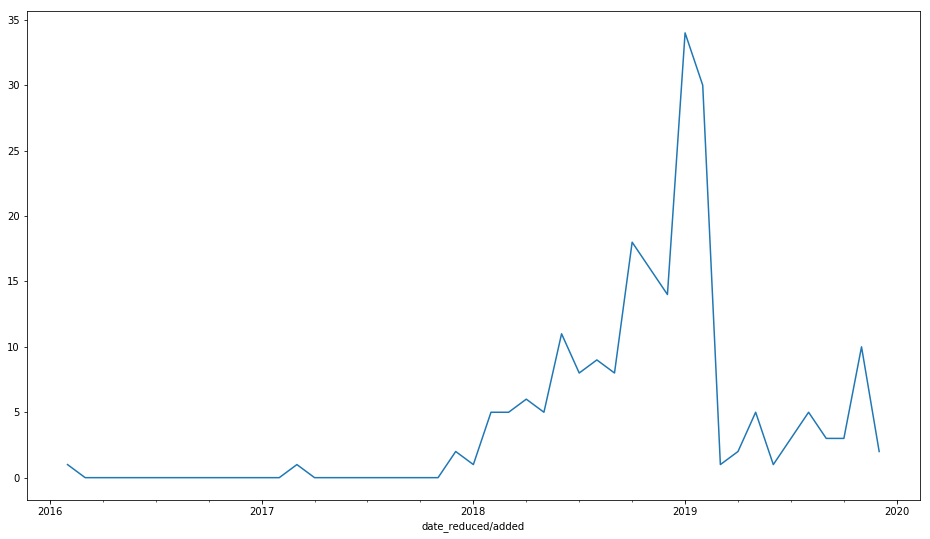

In [107]:
fig, ax = plt.subplots(figsize=(16,9))

df['date_reduced/added'] = pd.to_datetime(df['date_reduced/added'])
df_added = df.set_index('date_reduced/added').resample('M')['price'].count().plot(ax=ax)

plt.show()

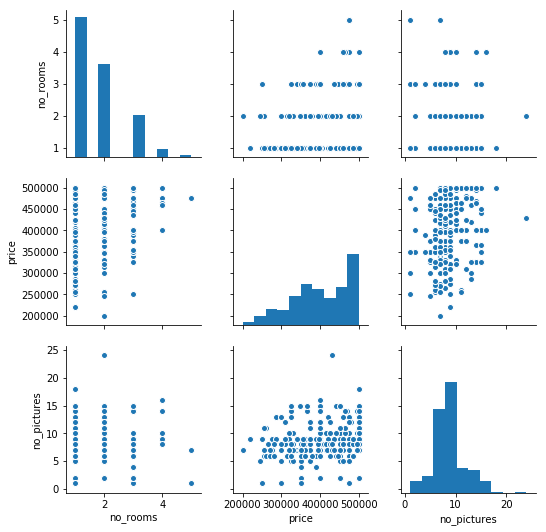

In [116]:
# fig, ax = plt.subplots(figsize=(16,9))

sns.pairplot(df[['no_rooms','price','no_pictures']])

plt.show()

In [51]:
borough_shape_file_location = 'C:/Users/ballinj/housing/london_boroughs/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
borough_links = pd.read_csv('london_borough_list.csv')
map_df = gpd.read_file(borough_shape_file_location)

map_df = map_df.set_index('NAME')
borough_links = borough_links.set_index('borough')

map_df = pd.concat([map_df, borough_links], axis=1)

map_df['1_bed_percentage'] = map_df['difference']/map_df['no_properties (1+ beds)']

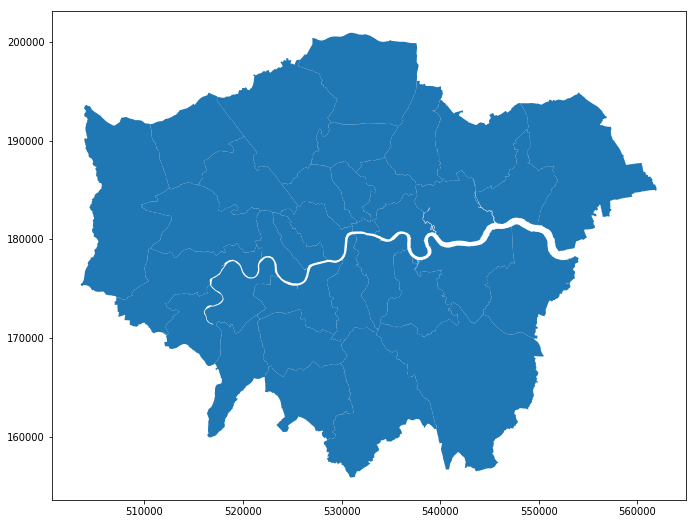

In [48]:
fig, ax = plt.subplots(figsize=(16,9))
map_df.plot(ax=ax)
plt.show()

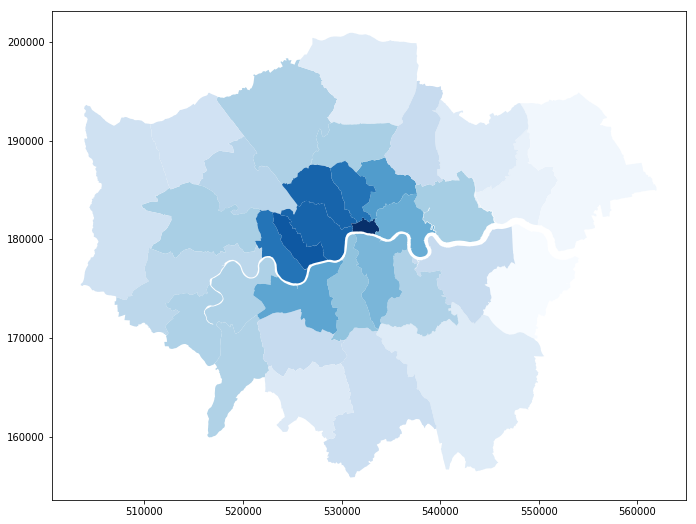

In [52]:
fig, ax = plt.subplots(figsize=(16,9))

map_df.plot(column='1_bed_percentage', cmap='Blues', ax=ax)

plt.show()